# Taller 1 de NLP: Procesando textos con técnicas simples

**Jessenia Piza, Paula Lorena López, Laura Alejandra Salazar.**

Para este taller deberás disponer de algunas librerías como scikit-learn, NLTK, spacy y fbpca. 

En este taller trabajaremos con el dataset `progressive-tweet-sentiment` el cual tiene algunos tweets recopilados y categorizados en 4 clases: 'Legalization of Abortion', 'Hillary Clinton', 'Feminist Movement', 'Atheism'. 

De esta manera, leeremos los datos por medio de la librería `pandas.

In [1]:
import pandas as pd
df = pd.read_csv("progressive-tweet-sentiment.csv",encoding='latin-1')
df = df[["target", "tweet"]]
df.head()

,target,tweet
0,Legalization of Abortion,Thank you for another day of life Lord. #Chris...
1,Legalization of Abortion,@rosaryrevival Lovely to use Glorious Mysterie...
2,Legalization of Abortion,@Niall250 good thing is that #DUP have consist...
3,Legalization of Abortion,"So, you tell me... is murder okay if the victi..."
4,Legalization of Abortion,@HillaryClinton Don't you mean to say (all chi...


## Punto 1
Realice procedimientos para preprocesar texto cómo: tokenizar, convertir a minúsculas y remover puntuaciones y algunos carácteres especiales (para esto puede usar expresiones regulares con la librería re, eliminar stopwords, stemming y lemmatization. Al final, el resultado de dicho procesamiento debe ser un texto (no una lista de palabras). Sugerencia: inicie y finalice con métodos de strings de python como .join() o .split().

Importamos todas las librerías que utilizaremos a lo largo del taller.

In [2]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition
from collections import Counter
from tqdm import tqdm
from scipy.sparse import csr_matrix
import math
import operator
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

Definimos la función que tokeniza cada oración que va entrando. 
Esto se hace con el fin de que sea mas sencillo el análisis de las palabras.

In [3]:
def tokenizer(tweet):
  token = nltk.RegexpTokenizer(r"\w+")
  list_tweet = token.tokenize(tweet)
  ps = nltk.stem.PorterStemmer()
  list_tweet = [x.lower() for x in list_tweet]
  list_tweet = [ps.stem(x) for x in list_tweet]
  return " ".join(list_tweet)


In [4]:
df["tweet"] = df["tweet"].apply(tokenizer)
df["target"] = df["target"].apply(tokenizer)
df.head()

,target,tweet
0,legal of abort,thank you for anoth day of life lord christian...
1,legal of abort,rosaryreviv love to use gloriou mysteri dure e...
2,legal of abort,niall250 good thing is that dup have consist s...
3,legal of abort,so you tell me is murder okay if the victim is...
4,legal of abort,hillaryclinton don t you mean to say all child...


## Punto 2
. Realice un estrategia de Bag of Words (BoW).  Produzca una mátriz término-documento, en este caso un simple conteo de palabras (`sklearn.feature_extraction.text.CountVectorizer`). ¿Cúal es el vocabulario? ¿Cuál es la dimensión de la matriz?

Se crea un vocabulario teniendo en cuentas las palabras ya tokenizadas. Estas palabras son sacadas de los tweets importados.

In [5]:
vectorizer = CountVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(df['tweet']).todense()

In [6]:
vocab = vectorizer.get_feature_names()
vocab = np.array(vocab) 
vocab[1050:1070]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['earn', 'earth', 'earthquak', 'easi', 'easier', 'easili',
       'eastertid', 'easyweightloss', 'eat', 'eco', 'econom', 'economi',
       'ecstat', 'ed', 'ed_miliband', 'edg', 'edgi', 'edm', 'educ',
       'effect'], dtype='<U31')

Podemos evidenciar alguna palabras del vocabulario. 
El vocabulario tiene una dimensión de 3795.

In [7]:
vocab.shape

(3795,)

## Punto 3
Escoga un número de tópicos o temas (no muy grande, entre 4 y 10) y realice un análisis mediante factorización de valores singulares (SVD) de la matriz de término-documento obtenida anteriormente. ¿Qué interpretación puede realizar? ¿Qué puede concluir a través de las matrices U, S y V? . Recuerde que este procedimiento es aprendizaje NO supervisado.

Para hacer la factorización de los valores singulares (SVD), se deben observar las matrices dadas por la función `Linalg`

In [8]:
U, s, Vh = linalg.svd(vectors, full_matrices=False)

In [9]:
print(U.shape, s.shape, Vh.shape)

(1159, 1159) (1159,) (1159, 3795)


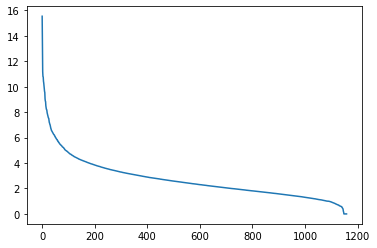

In [10]:
plt.plot(s);

Podemos evidenciar que el cambio de comportamieto de la gráfica se da en 6, así que veremos el comportamiento en estos priimeros 6 datos.

Para una observación más detallada se tendrá en cuenta el comportamiento de las primera  columnas de la matriz.

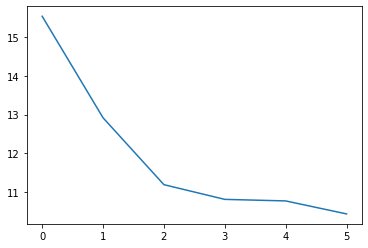

In [11]:
plt.plot(s[:6])

Ahora bien, escogeremos como máximo de tópicos 6.

In [12]:
num_top_words=6

def show_topics(a, vocab):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]


In [13]:
show_topics(Vh[:10], vocab)

['_____ ____ ding dong genitalian lajouetrein',
 'god love know life don thi',
 'peopl abort don life hillari right',
 'know don best feminist men want',
 'hillaryclinton know hillari world best presid',
 'peopl feminist want rt hillaryclinton thi',
 'peopl abort know best women life',
 'don love women want rt abort',
 'rt readi 2016 marcorubio know futuretxlead',
 'hillaryclinton peopl right world rt love']

Podemos evidenciar que la religión, el aborto y el feminismo con los temas principales de los tweets teniendo en cuenta el método SVD.

## Punto 4
Repita `(3)` pero realizando una factorización no negativa de matrices (NMF). ¿Qué interpreta a partir de las matrices obtenidas H y W?

In [14]:
model_NMF = decomposition.NMF(n_components=5, init='nndsvda', random_state=1)  
W = model_NMF.fit_transform(vectors) #Transformed data
H = model_NMF.components_ #Factorization matrix, sometimes called ‘dictionary’.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Teniendo el resultado de la factorización no negativa de matrices (NMF), podemos obtener los temas principales de los que se tratan.


In [15]:
show_topics(H, vocab)

['women men equal feminist need make',
 'god love pray bless mother sinner',
 'right don peopl abort feminist want',
 'know best don happi way alway',
 'hillaryclinton hillari rt world clinton thi']

La religión, el aborto y el feminismo también son los temas principales según el método.

# Punto 5

Implemente desde cero el método de Topic Frequency - Inverse Document Frequency (TF-IDF). Compare el resultado en el dataset de tweets con la implementación de scikit-learn `sklearn.feature_extraction.text.TfidfVectorizer`. 

### **Implementación con _Scikit_learn_**

In [16]:
tw = df['tweet'].tolist()

In [17]:
vector_tfidf = TfidfVectorizer(stop_words='english')
X = vector_tfidf.fit_transform(df['tweet'])
print(X.shape)

(1159, 3795)


### **Implementado desde cero:**

Se tienen dos funciones necesarias para crear el algoritmo.

In [18]:
def IDF(txt, unique_words):
  idf_dict={}
  N=len(txt)
  for i in unique_words:
    count=0
    for sen in txt:
      if i in sen.split():
        count += 1
      idf_dict[i]=(math.log((1+N)/(count+1)))+1
  return idf_dict

def fit(txt):
  unique_words = set()
  if isinstance(txt, (list,)):
    for x in txt:
      for y in x.split():
        if len(y)<2:
          continue
        unique_words.add(y)
    unique_words = sorted(list(unique_words))
    vocab = {j:i for i,j in enumerate(unique_words)}
    Idf_values=IDF(txt, unique_words)
  return vocab, Idf_values

In [19]:
Vocabulary, idf_of_vocab = fit(tw)

Con esto, finalmente se crea una nueva función que tendrá la infromación necesaria para procesarla y el algoritmo sea ejecutado.

In [20]:
def transform(txt, vocabulary, idf_values):
    sparse_matrix= csr_matrix( (len(txt), len(vocabulary)))
    for row  in range(0,len(txt)):
      words_sentence=Counter(txt[row].split())
      for word in txt[row].split():
          if word in  list(vocabulary.keys()):
              tf_idf_value=(words_sentence[word]/len(txt[row].split()))*(idf_values[word])
              sparse_matrix[row,vocabulary[word]]=tf_idf_value
    output =normalize(sparse_matrix, norm='l2', axis=1, copy=True, return_norm=False)
    return output

In [21]:
tf_idf = transform(tw, Vocabulary, idf_of_vocab)
print(tf_idf.shape)

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


(1159, 3977)


Finalmente, tenemos el algortimo. 
Podemos evidenciar que el algortimo de la librería `scikit learn`, tiene un resultado parecido al ejecutado.

## Punto 6
Repita los puntos `(3)` y `(4)` pero con base en la matriz obtenida al realizar TF-IDF


In [22]:
tf_idf
tf_idf = tf_idf.todense()

In [23]:
U2, S2, Vh2 = linalg.svd(tf_idf, full_matrices=False)
print(U2.shape, S2.shape, Vh2.shape)

(1159, 1159) (1159,) (1159, 3977)


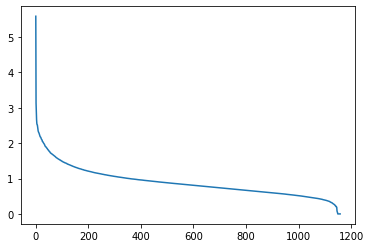

In [24]:
plt.plot(S2);

In [25]:
show_topics(Vh2[:5], list(Vocabulary.keys()))

['__ dong ding ____ _____ demias20',
 'you your what can don do',
 'you god the of your and',
 'to be the god it will',
 'to be have want we are']

Podemos evidenciar que el tema principal es la religión.

Ahora bien, en la factorización no negativa de matrices (*NMF*) y tomar las matrices *H* y *W*, se hace uso de la función de la librería. 

In [26]:
model_NMF2 = decomposition.NMF(n_components=5, init='nndsvda', random_state=1)  
W2 = model_NMF2.fit_transform(np.asarray(tf_idf)) #Transformed data
H2 = model_NMF2.components_ 

Teniendo el rsultado de la factorización no negativa de matrices (NMF), podemos obtener los temas principales de los que se tratan.


In [27]:
H2.shape, W2.shape

((5, 3977), (1159, 5))

In [28]:
show_topics(H2, list(Vocabulary.keys()))

['the of and is god for',
 'you your know if can re',
 'to be want have hillari women',
 'are in for readi 2016 marcorubio',
 'not is it abort what do']

Aquí podemos evidenciar que los tema principales evidentes son la religión y Hillary Clinton.

## Punto 7
Use PCA y realice una interpretación similar a la de la factorizaciones anteriores usando la matriz TF-IDF (¿Qué significa las componentes principales, qué palabras aportan más a cada componente?).

In [29]:
df2 = pd.DataFrame(tf_idf, tw, list(Vocabulary.keys()))

Utilizaremos 6 componentes para analizar `PCA`. 
De esta manera, veremos cuales son las cinco palabras más usadas en algunas de las componentes.

In [30]:
pca = PCA(n_components = 6)
pca.fit_transform(df2)
pcaDf = pd.DataFrame(pca.components_, columns=df2.columns, index=['1', '2', '3', '4', '5', '6'])
pcaDf = pcaDf.T


In [31]:
pcaDf["2"].nlargest(5)

you    0.371253
the    0.341071
god    0.308934
of     0.278858
and    0.124224
Name: 2, dtype: float64

In [32]:
pcaDf["4"].nlargest(5)

women    0.390151
the      0.288121
are      0.271087
men      0.253248
of       0.241734
Name: 4, dtype: float64

In [33]:
pcaDf["5"].nlargest(5)

not     0.369851
is      0.359954
what    0.273416
it      0.180989
do      0.178358
Name: 5, dtype: float64

In [34]:
pcaDf["6"].nlargest(5)

for     0.301303
god     0.274247
what    0.209738
do      0.135064
us      0.134902
Name: 6, dtype: float64

## Punto 8.
 Hasta ahora hemos realizado aprendizaje no supervisado, pero también podemos aplicar aprendizaje supervisado. Use las matrices de término-documento anteriores para realizar una clasificación, usando algunos modelos (Multinomial Naive Bayes, Random Forest, LDA, etc.). Debe tener en cuenta que para evaluar correctamente los resultados (al menos) debe usar una partición training-test (recomendable validación cruzada). Compare y discute los resultados a partir de diversas métricas de desempeño (no olvide la matriz de confusión). Sugerencia: realice la vectorización (conteo de palabras) y la clasificación en un Pipeline. 

In [35]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import sklearn as sk
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

El clasificador `Multinomial Naive Bayes` es un clasificador probabilístico basados ​​en la aplicación del teorema de Bayes. Se encuentran entre los modelos de red bayesianos más simples pero, junto con la estimación pueden lograr altos niveles de precisión.

In [36]:
def MultinomialNaiveBayes(X_train, Y_train, X_test, Y_test):
  clf = MultinomialNB()
  clf.fit(X_train, Y_train)
  y_pred = clf.predict(X_test)
  accuracy = sk.metrics.accuracy_score(Y_test, y_pred)
  return clf, y_pred, accuracy

In [37]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
X = np.asarray(vectorizer_tfidf.fit_transform(df.tweet).todense())
Y = np.asarray(df.target)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)


In [38]:
clf, y_pred, acc = MultinomialNaiveBayes(X_train, Y_train, X_test, Y_test)


Por otro lado, veremos el accuracy que tuvo el modelo

In [39]:
print('Accuracy: '+ str(acc))

Accuracy: 0.7025862068965517


Tiene un accuracy de aproximadamente 70%.

In [40]:
data = {'Y_test':    Y_test,
        'y_pred': y_pred
        }

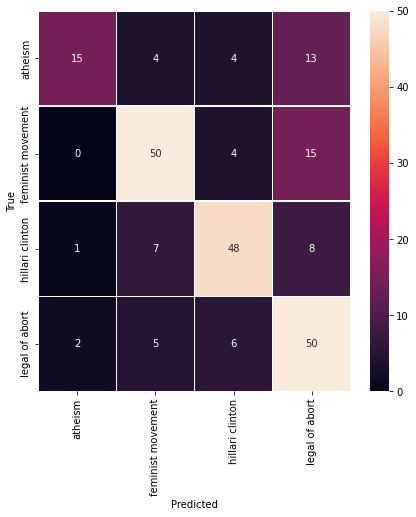

In [41]:
df = pd.DataFrame(data, columns=['Y_test','y_pred'])
confusion_matrix = pd.crosstab(df['Y_test'], df['y_pred'], rownames=['True'], colnames=['Predicted'])
fig, ax = plt.subplots(figsize=(7,7))
ax = sn.heatmap(confusion_matrix, annot=True, linewidths=.5)
plt.show()

Note que, tiene un porcentaje muy bueno de eficacia. 
En la diagonal tiene los valores mas alto de toda la matriz. Sin embargo, confunde el ateísmo con la lagalización del aborto. 
Los demás temas los acierta muy bien 

